# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=65,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_17-31-59/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4799 | MulticlassF1Score=0.1949
Batch-30 : CrossEntropyLoss=2.4733 | MulticlassF1Score=0.2386
Batch-45 : CrossEntropyLoss=2.4654 | MulticlassF1Score=0.2803
Batch-60 : CrossEntropyLoss=2.4089 | MulticlassF1Score=0.3122
Batch-75 : CrossEntropyLoss=2.4266 | MulticlassF1Score=0.3361
Batch-90 : CrossEntropyLoss=2.4378 | MulticlassF1Score=0.3533
Batch-105: CrossEntropyLoss=2.3915 | MulticlassF1Score=0.3692
Batch-120: CrossEntropyLoss=2.4125 | MulticlassF1Score=0.3904
Batch-135: CrossEntropyLoss=2.3772 | MulticlassF1Score=0.4105
Batch-150: CrossEntropyLoss=2.3551 | MulticlassF1Score=0.4322
Batch-165: CrossEntropyLoss=2.3579 | MulticlassF1Score=0.4541
Batch-180: CrossEntropyLoss=2.3496 | MulticlassF1Score=0.4739
Batch-195: CrossEntropyLoss=2.3349 | MulticlassF1Score=0.4942
Batch-210: CrossEntropyLoss=2.3214 | MulticlassF1Score=0.5121
Batch-225: CrossEntropyLoss=2.3247 | MulticlassF1Score=0.5291
Batch-226: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.5299

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7595
Batch-30 : CrossEntropyLoss=2.3196 | MulticlassF1Score=0.7672
Batch-45 : CrossEntropyLoss=2.3320 | MulticlassF1Score=0.7644
Batch-60 : CrossEntropyLoss=2.3285 | MulticlassF1Score=0.7631
Batch-63 : CrossEntropyLoss=2.3232 | MulticlassF1Score=0.7638

Training   : Mean CrossEntropyLoss = 2.4050 | Mean MulticlassF1Score = 0.3746
Validation : Mean CrossEntropyLoss = 2.3224 | Mean MulticlassF1Score = 0.7643

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3274 | MulticlassF1Score=0.7648
Batch-30 : CrossEntropyLoss=2.3257 | MulticlassF1Score=0.7642
Batch-45 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7698
Batch-60 : CrossEntropyLoss=2.3225 | MulticlassF1Score=0.7741
Batch-75 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7758
Batch-90 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7764
Batch-105: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.7793
Batch-120: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.7794
Batch-135: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7817
Batch-150: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7814
Batch-165: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7825
Batch-180: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7828
Batch-195: CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7838
Batch-210: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7843
Batch-225: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7852
Batch-226: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7852

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7936
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7912
Batch-45 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.7908
Batch-60 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7899
Batch-63 : CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7898

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3152 | Mean MulticlassF1Score = 0.7767
Validation : Mean CrossEntropyLoss = 2.3131 | Mean MulticlassF1Score = 0.7939

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7936
Batch-30 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7924
Batch-45 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7947
Batch-60 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7943
Batch-75 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.7952
Batch-90 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7956
Batch-105: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7957
Batch-120: CrossEntropyLoss=2.3162 | MulticlassF1Score=0.7964
Batch-135: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7976
Batch-150: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7978
Batch-165: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7982
Batch-180: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7977
Batch-195: CrossEntropyLoss=2.3236 | MulticlassF1Score=0.7980
Batch-210: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7981
Batch-225: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7991
Batch-226: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.7992

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8037
Batch-30 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8052
Batch-45 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8039
Batch-60 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8037
Batch-63 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8034

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3102 | Mean MulticlassF1Score = 0.7967
Validation : Mean CrossEntropyLoss = 2.3086 | Mean MulticlassF1Score = 0.8030

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8023
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8055
Batch-45 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8053
Batch-60 : CrossEntropyLoss=2.3241 | MulticlassF1Score=0.8057
Batch-75 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8054
Batch-90 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8072
Batch-105: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8080
Batch-120: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8081
Batch-135: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8095
Batch-150: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8110
Batch-165: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8121
Batch-180: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8130
Batch-195: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8139
Batch-210: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8147
Batch-225: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8155
Batch-226: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8156

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8287
Batch-30 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8255
Batch-45 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8250
Batch-60 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8260
Batch-63 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3050 | Mean MulticlassF1Score = 0.8093
Validation : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8252

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8263
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8267
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8272
Batch-60 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8275
Batch-75 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8281
Batch-90 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8292
Batch-105: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8295
Batch-120: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8303
Batch-135: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8298
Batch-150: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8297
Batch-165: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8294
Batch-180: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8296
Batch-195: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8296
Batch-210: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8305
Batch-225: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8307
Batch-226: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8307

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8307
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8329
Batch-45 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8345
Batch-60 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8345
Batch-63 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8343

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8285
Validation : Mean CrossEntropyLoss = 2.2989 | Mean MulticlassF1Score = 0.8339

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8327
Batch-30 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8328
Batch-45 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8336
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8343
Batch-75 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8342
Batch-90 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8355
Batch-105: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8351
Batch-120: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8359
Batch-135: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8373
Batch-150: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8403
Batch-165: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8425
Batch-180: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8445
Batch-195: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8464
Batch-210: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8479
Batch-225: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8491
Batch-226: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8492

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8623
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8641
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8617
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8617
Batch-63 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8619

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2946 | Mean MulticlassF1Score = 0.8388
Validation : Mean CrossEntropyLoss = 2.2907 | Mean MulticlassF1Score = 0.8613

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8732
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8745
Batch-45 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8772
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8785
Batch-75 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8786
Batch-90 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8787
Batch-105: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8790
Batch-120: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8794
Batch-135: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8803
Batch-150: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8808
Batch-165: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8815
Batch-180: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8816
Batch-195: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8819
Batch-210: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8820
Batch-225: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8824
Batch-226: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8824

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8771
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8776
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8789
Batch-60 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8796
Batch-63 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8795

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8793
Validation : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8767

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8810
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8826
Batch-45 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8845
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8855
Batch-75 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8854
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8864
Batch-105: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8867
Batch-120: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8867
Batch-135: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8874
Batch-150: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8872
Batch-165: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8864
Batch-180: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8865
Batch-195: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8872
Batch-210: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8874
Batch-225: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8875
Batch-226: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8874

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8836
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8791
Batch-45 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8787
Batch-60 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8794
Batch-63 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8794

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8856
Validation : Mean CrossEntropyLoss = 2.2853 | Mean MulticlassF1Score = 0.8814

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8885
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8907
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8904
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8911
Batch-75 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8905
Batch-90 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8902
Batch-105: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8905
Batch-120: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8905
Batch-135: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8903
Batch-150: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8896
Batch-165: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8905
Batch-180: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8904
Batch-195: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8903
Batch-210: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8903
Batch-225: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8902
Batch-226: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8902

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8862
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8815
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8814
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8820
Batch-63 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8824

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8900
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8833

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8887
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8903
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8928
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8929
Batch-75 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8931
Batch-90 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8929
Batch-105: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8931
Batch-120: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8927
Batch-135: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8929
Batch-150: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8925
Batch-165: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8920
Batch-180: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.8923
Batch-195: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8919
Batch-210: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8919
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.8922
Batch-226: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8921

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8834
Batch-30 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8811
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8837
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8825
Batch-63 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8823

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8921
Validation : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8822

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8948
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8938
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8928
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8935
Batch-75 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8937
Batch-90 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8935
Batch-105: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8927
Batch-120: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8922
Batch-135: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8926
Batch-150: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8927
Batch-165: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8931
Batch-180: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8932
Batch-195: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8929
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8932
Batch-225: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8931
Batch-226: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8931

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8785
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8800
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8821
Batch-60 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8832
Batch-63 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8835

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8932
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8807

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8884
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8920
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8936
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8935
Batch-75 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8947
Batch-90 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8947
Batch-105: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8946
Batch-120: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8953
Batch-135: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8952
Batch-150: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8956
Batch-165: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8956
Batch-180: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8957
Batch-195: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8959
Batch-210: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8958
Batch-225: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8955
Batch-226: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8954

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8870
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8847
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8846
Batch-63 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8841

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8942
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8859

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8989
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8963
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8963
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8968
Batch-90 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8971
Batch-105: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8972
Batch-120: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8974
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8967
Batch-150: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8966
Batch-165: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8962
Batch-180: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8962
Batch-195: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8965
Batch-210: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8968
Batch-225: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8967
Batch-226: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8968

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8812
Batch-30 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8821
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8842
Batch-60 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8847
Batch-63 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8846

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8970
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8828

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8947
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8951
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8958
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8970
Batch-75 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8967
Batch-90 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8964
Batch-105: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8965
Batch-120: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8966
Batch-135: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8967
Batch-150: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8971
Batch-165: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8971
Batch-180: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8970
Batch-195: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8974
Batch-210: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8975
Batch-225: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8976
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8976

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8843
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8837
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8843
Batch-63 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8843

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2793 | Mean MulticlassF1Score = 0.8968
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8858

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9010
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9004
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9001
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8995
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8990
Batch-90 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8996
Batch-105: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8992
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8995
Batch-135: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8993
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8992
Batch-165: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8989
Batch-180: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8984
Batch-195: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8981
Batch-210: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8982
Batch-225: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8984
Batch-226: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8985

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8801
Batch-30 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8805
Batch-45 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8827
Batch-60 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8830
Batch-63 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8832

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.8992
Validation : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8809

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9014
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8977
Batch-45 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8973
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8971
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8976
Batch-90 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8983
Batch-105: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8978
Batch-120: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8985
Batch-135: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8981
Batch-150: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8985
Batch-165: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8991
Batch-180: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8994
Batch-195: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8996
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.8998
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9000
Batch-226: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8999

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8854
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8868
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8868
Batch-63 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8862

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2785 | Mean MulticlassF1Score = 0.8984
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8867

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9040
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9033
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9040
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9049
Batch-75 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9037
Batch-90 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9031
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9033
Batch-120: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9041
Batch-135: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9042
Batch-150: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9046
Batch-165: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9045
Batch-180: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9049
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9051
Batch-210: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9056
Batch-225: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9052
Batch-226: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9053

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8902
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8908
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8918
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8918

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9043
Validation : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8914

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9119
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9108
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9112
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9105
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9095
Batch-90 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9096
Batch-105: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9097
Batch-120: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9095
Batch-135: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9091
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9091
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9089
Batch-180: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9089
Batch-195: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9089
Batch-210: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9090
Batch-225: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9093
Batch-226: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.9092

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8931
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8950
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8956
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8937
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8934

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9097
Validation : Mean CrossEntropyLoss = 2.2806 | Mean MulticlassF1Score = 0.8945

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9131
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9144
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9107
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9101
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9108
Batch-90 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9107
Batch-105: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9113
Batch-120: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9113
Batch-135: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9111
Batch-150: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9104
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9107
Batch-180: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9106
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9105
Batch-210: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9104
Batch-225: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9107
Batch-226: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9106

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8930
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8941
Batch-45 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8942
Batch-60 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8939
Batch-63 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8937

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9114
Validation : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8932

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9132
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9135
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9129
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9107
Batch-75 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9107
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9112
Batch-105: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9107
Batch-120: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9104
Batch-135: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9107
Batch-150: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9105
Batch-165: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9109
Batch-180: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9112
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9115
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9115
Batch-225: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9116
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9117

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8977
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8941
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8939
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8945
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8944

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9115
Validation : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8955

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9151
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9134
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9128
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9135
Batch-90 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9131
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9129
Batch-120: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9132
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9131
Batch-150: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9129
Batch-165: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9130
Batch-180: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9129
Batch-195: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9129
Batch-210: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9126
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9125
Batch-226: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9125

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8978
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8955
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8941
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8952
Batch-63 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8949

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9133
Validation : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8957

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9140
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9135
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9130
Batch-90 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9121
Batch-105: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9122
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9125
Batch-135: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9125
Batch-150: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9126
Batch-165: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9128
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9128
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9130
Batch-210: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9134
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9135
Batch-226: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9135

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8942
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8968
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8947
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8950
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8948

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9130
Validation : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8951

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9120
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9143
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9145
Batch-90 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9143
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9148
Batch-120: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9146
Batch-135: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9141
Batch-150: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9141
Batch-165: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9147
Batch-180: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9149
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9146
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9146
Batch-225: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.9144
Batch-226: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9144

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.8967
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8924
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8961
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8963
Batch-63 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8964

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9142
Validation : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8946

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9170
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9152
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9143
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9143
Batch-75 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9152
Batch-90 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9153
Batch-105: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9152
Batch-120: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9154
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9148
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9149
Batch-165: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9149
Batch-180: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9148
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9149
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9152
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9149
Batch-226: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9149

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8988
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8966
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8961
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8960
Batch-63 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8960

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9150
Validation : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8964

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9198
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9187
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9176
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9161
Batch-75 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9154
Batch-90 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9147
Batch-105: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9154
Batch-120: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9149
Batch-135: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9150
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9151
Batch-165: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9150
Batch-180: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9154
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9154
Batch-210: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9152
Batch-225: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9152
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9152

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8926
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8962
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8967
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8961
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8959

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9160
Validation : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8952

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9192
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9181
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9157
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9155
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9162
Batch-90 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9157
Batch-105: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9153
Batch-120: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9158
Batch-135: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9164
Batch-150: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9159
Batch-165: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9156
Batch-180: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9157
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9156
Batch-210: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9155
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9155
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9155

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8943
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8931
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8959
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8956
Batch-63 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8955

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9164
Validation : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8950

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9147
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9159
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9165
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9194
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9221
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9243
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9265
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9280
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9294
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9306
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9317
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9326
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9336
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9340
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9340

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9198
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9198
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9209

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9255
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9198

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9420
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9417
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9416
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9412
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9237

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9416
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9414
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9418
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9418
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9417
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9420
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9420

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9216
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9223

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9415
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9242

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9432
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9428
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9460
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9476
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9492
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9504
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9514
Batch-195: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9522
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9528
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9533
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9533

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9415
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9414

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2620 | Mean MulticlassF1Score = 0.9469
Validation : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9425

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9634
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9637
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9630
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9634
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9634
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9631
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9629
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9628
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9626
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9627
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9628
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9631
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9631
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9632
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9439
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9435

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9630
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9444

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9621
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9650
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9652
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9645
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9642
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9645
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9435
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9434

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9647
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9447

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9628
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9633
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9640
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9639
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9644
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9645
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9646
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9645
Batch-150: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9646
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9648
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9648
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9647
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9642
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9441

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9645
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9650
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9641
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9648
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9647
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9647
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9646
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9650
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9442
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9440

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9642
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9645
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9648
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9649
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9647
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9651
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9646
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9646
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9649
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9649
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9445

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9644
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9435

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9655
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9651
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9651
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9655
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9655
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9653
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9652
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9651
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9651

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9436

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9445

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9644
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9644
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9651
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9649
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9656
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9653
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9652
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9440

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9651
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9429

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9656
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9661
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9656
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9442
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9657
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9439

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9450

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9450

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9667
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9668
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9449

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9469

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9659
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9444

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9665
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9434

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9673
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9671
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9670
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9671
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9669
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9453
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9453

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9448
Patience = 1/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9675
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9441

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9466

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9444

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9443
Patience = 2/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9647
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9660
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9658
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9660
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9668
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9448

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9449

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9426
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9439

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9421
Patience = 3/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9452

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9444

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9435

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9453

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9469
Patience = 4/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9439
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9453

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9453
Patience = 5/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2575
Best CrossEntropyLoss training    : 2.2647
Best MulticlassF1Score validation : 0.9672
Best MulticlassF1Score validation : 0.9435
Training duration                 : 2.2995 minutes.
Training date                     : 2022-10-19 11:39:32.885456+08:00


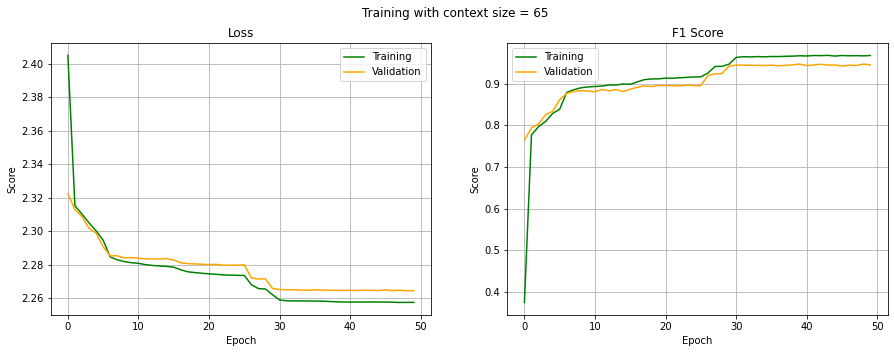

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9678, device='cuda:0'),
 tensor(0.9453, device='cuda:0'),
 tensor(0.9464, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9678, device='cuda:0'),
 tensor(0.9453, device='cuda:0'),
 tensor(0.9464, device='cuda:0'))

## Heatmap

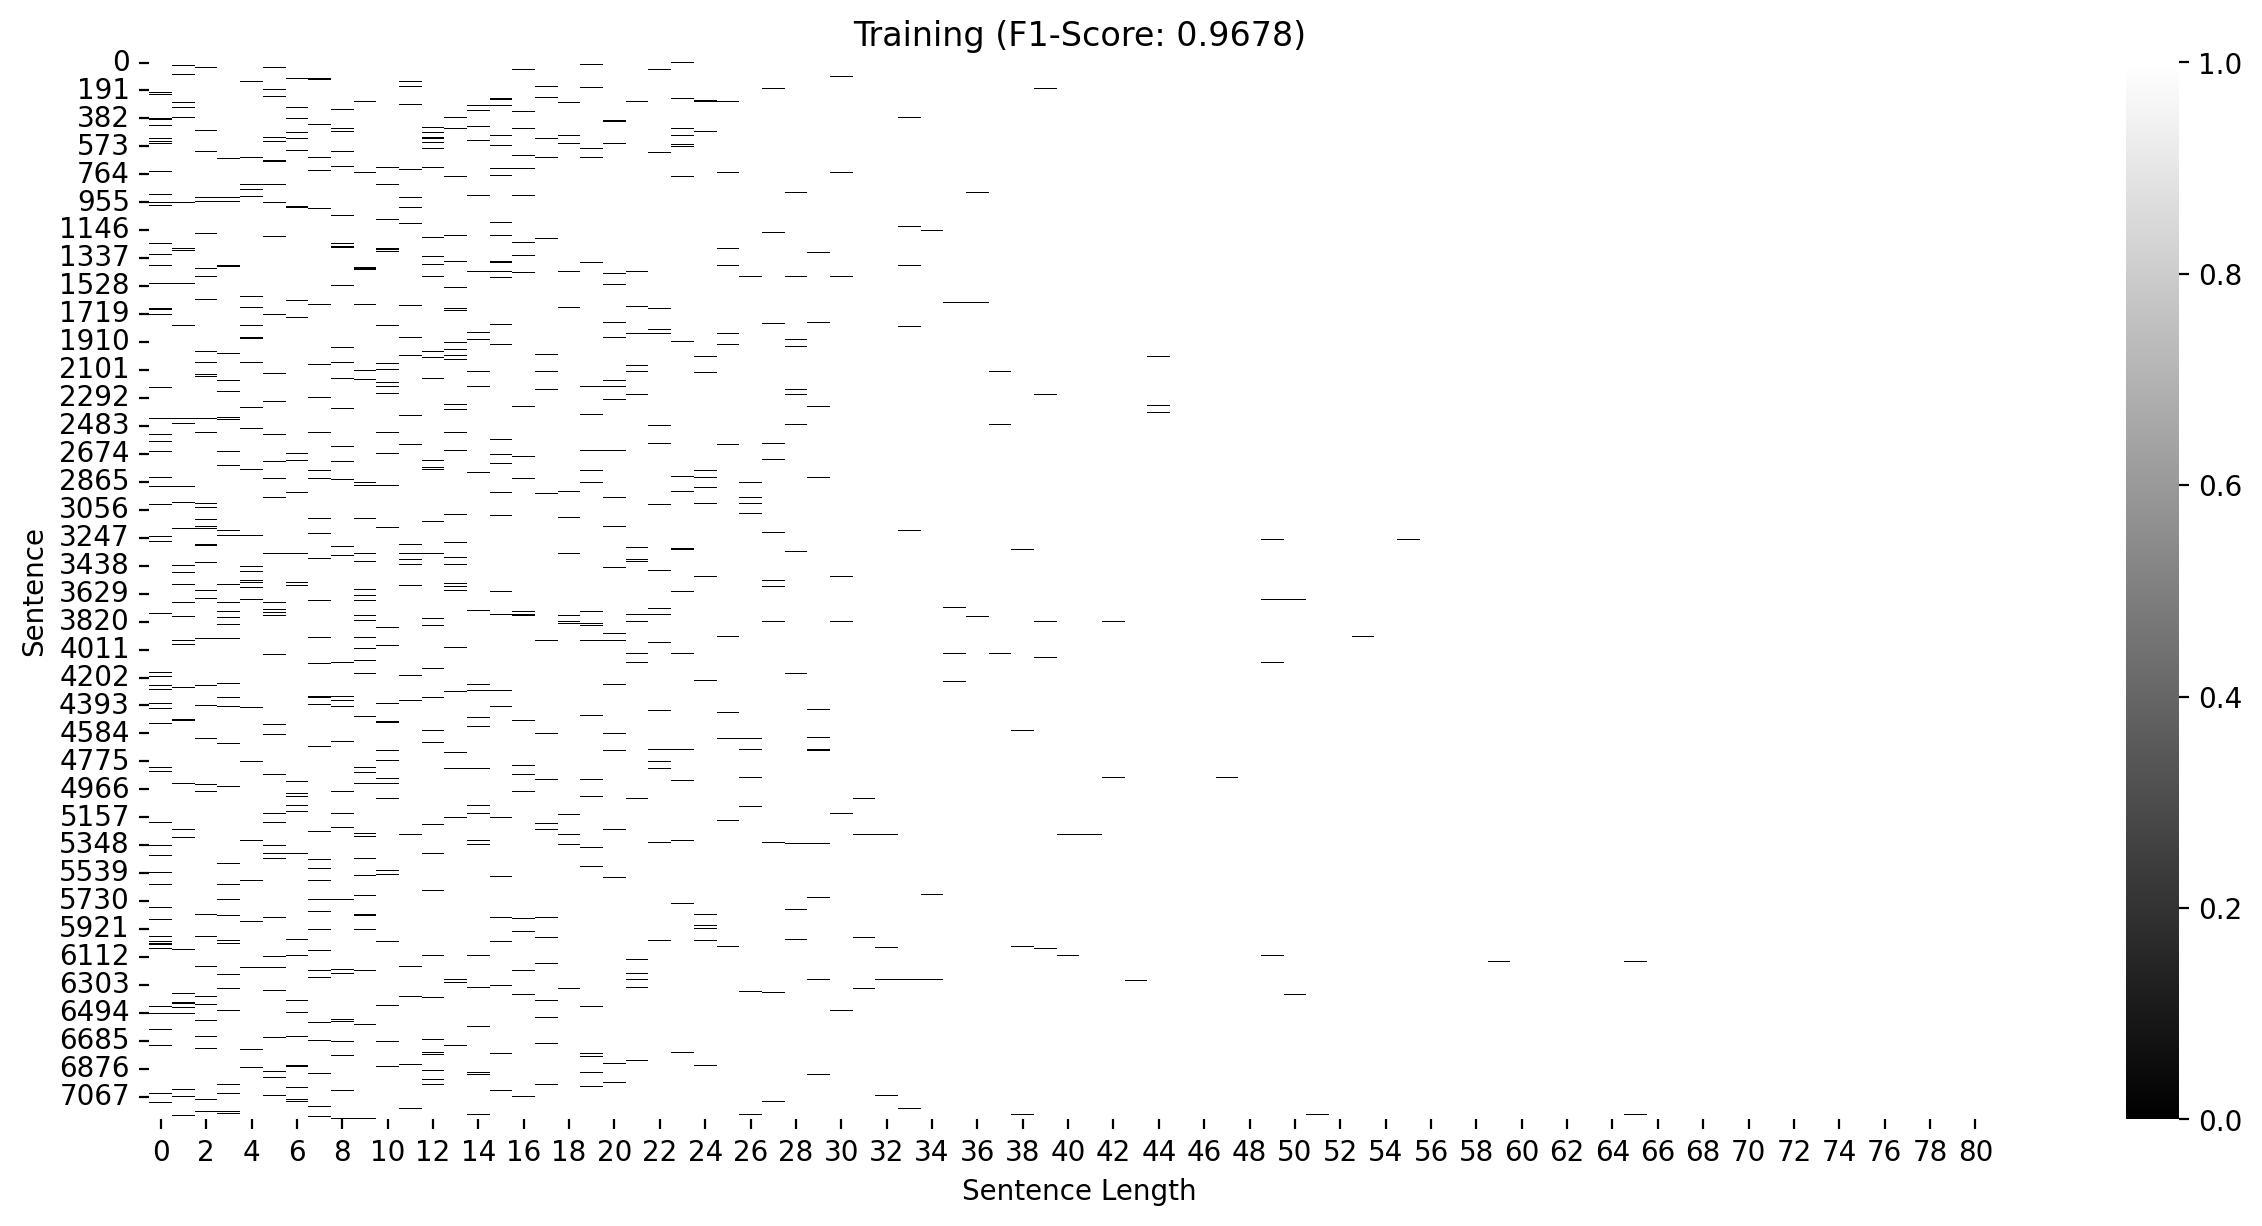

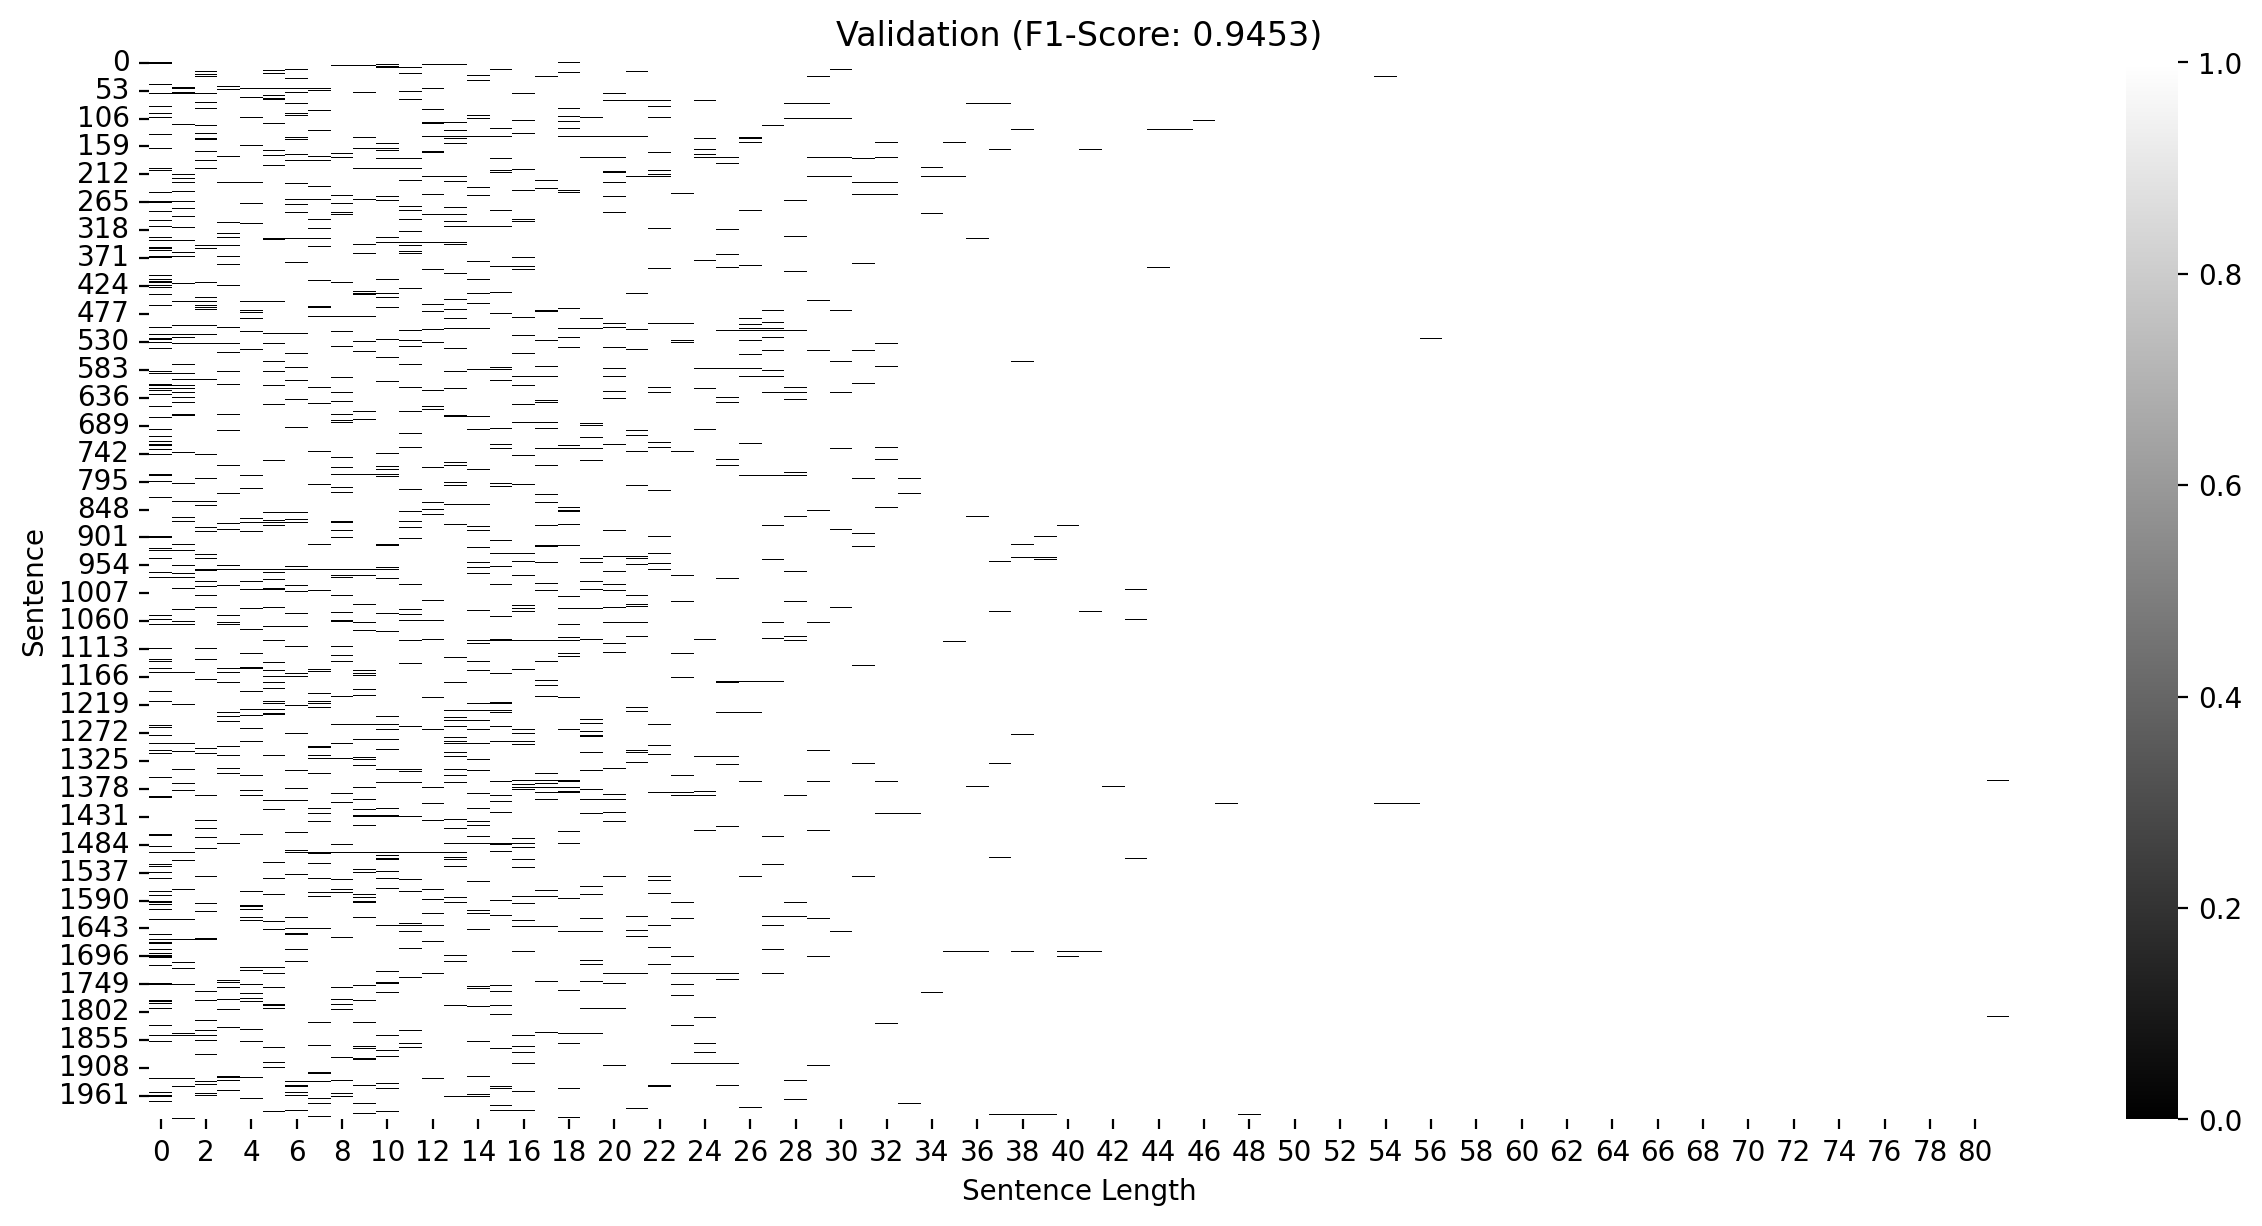

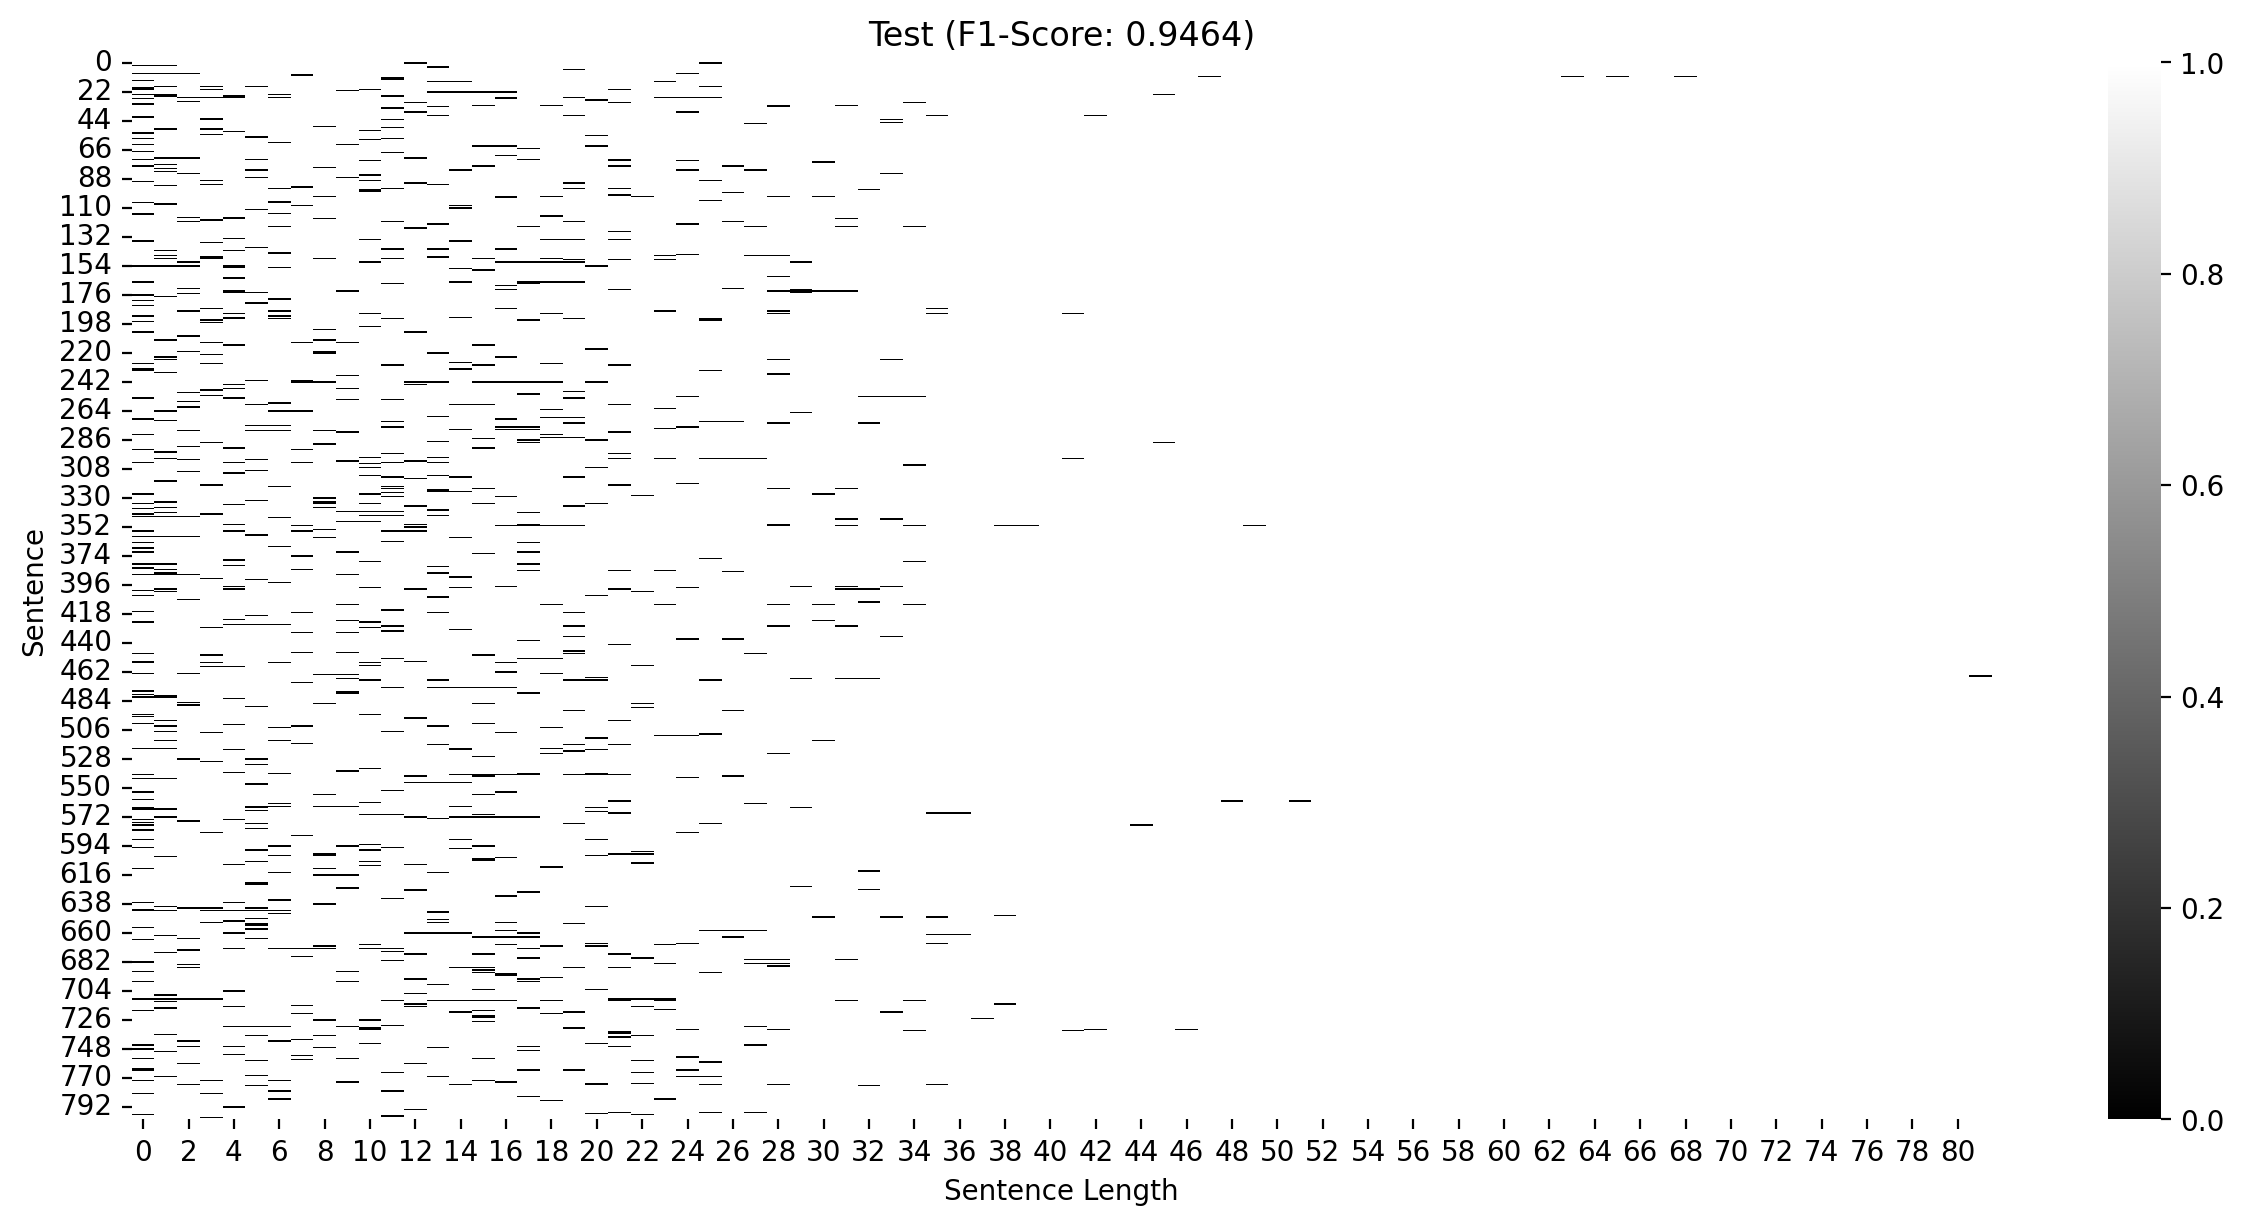

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


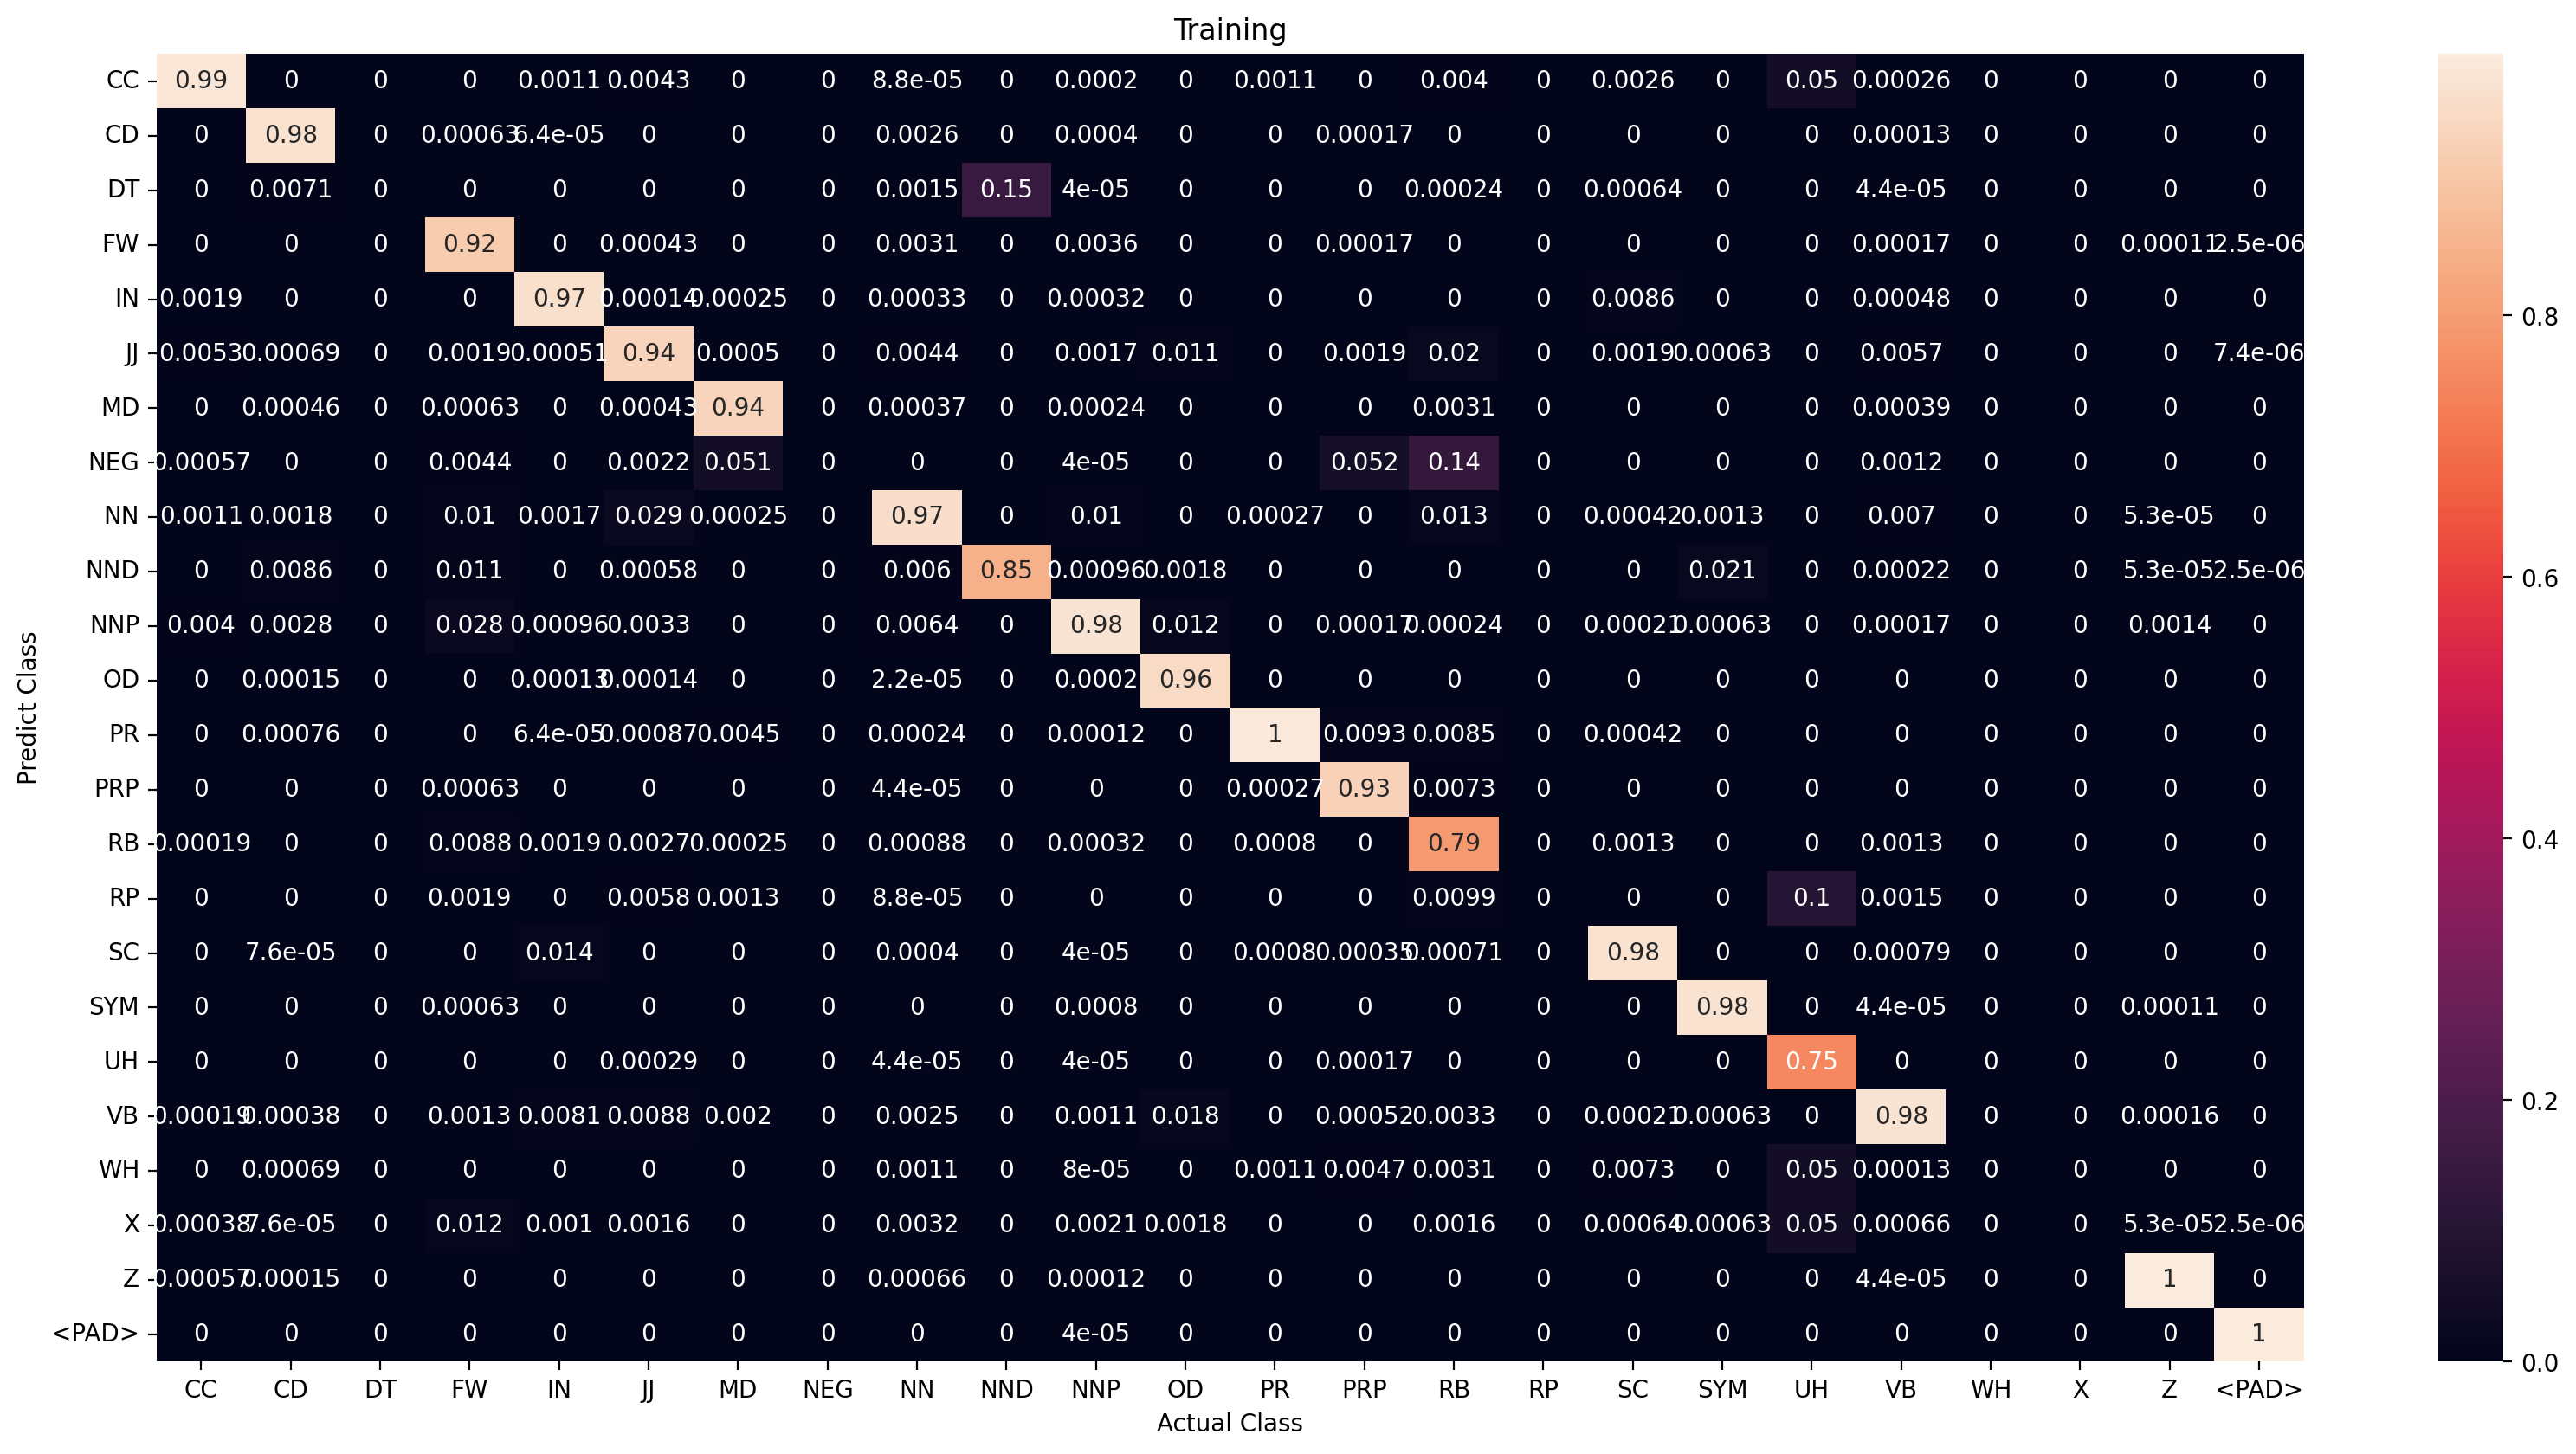

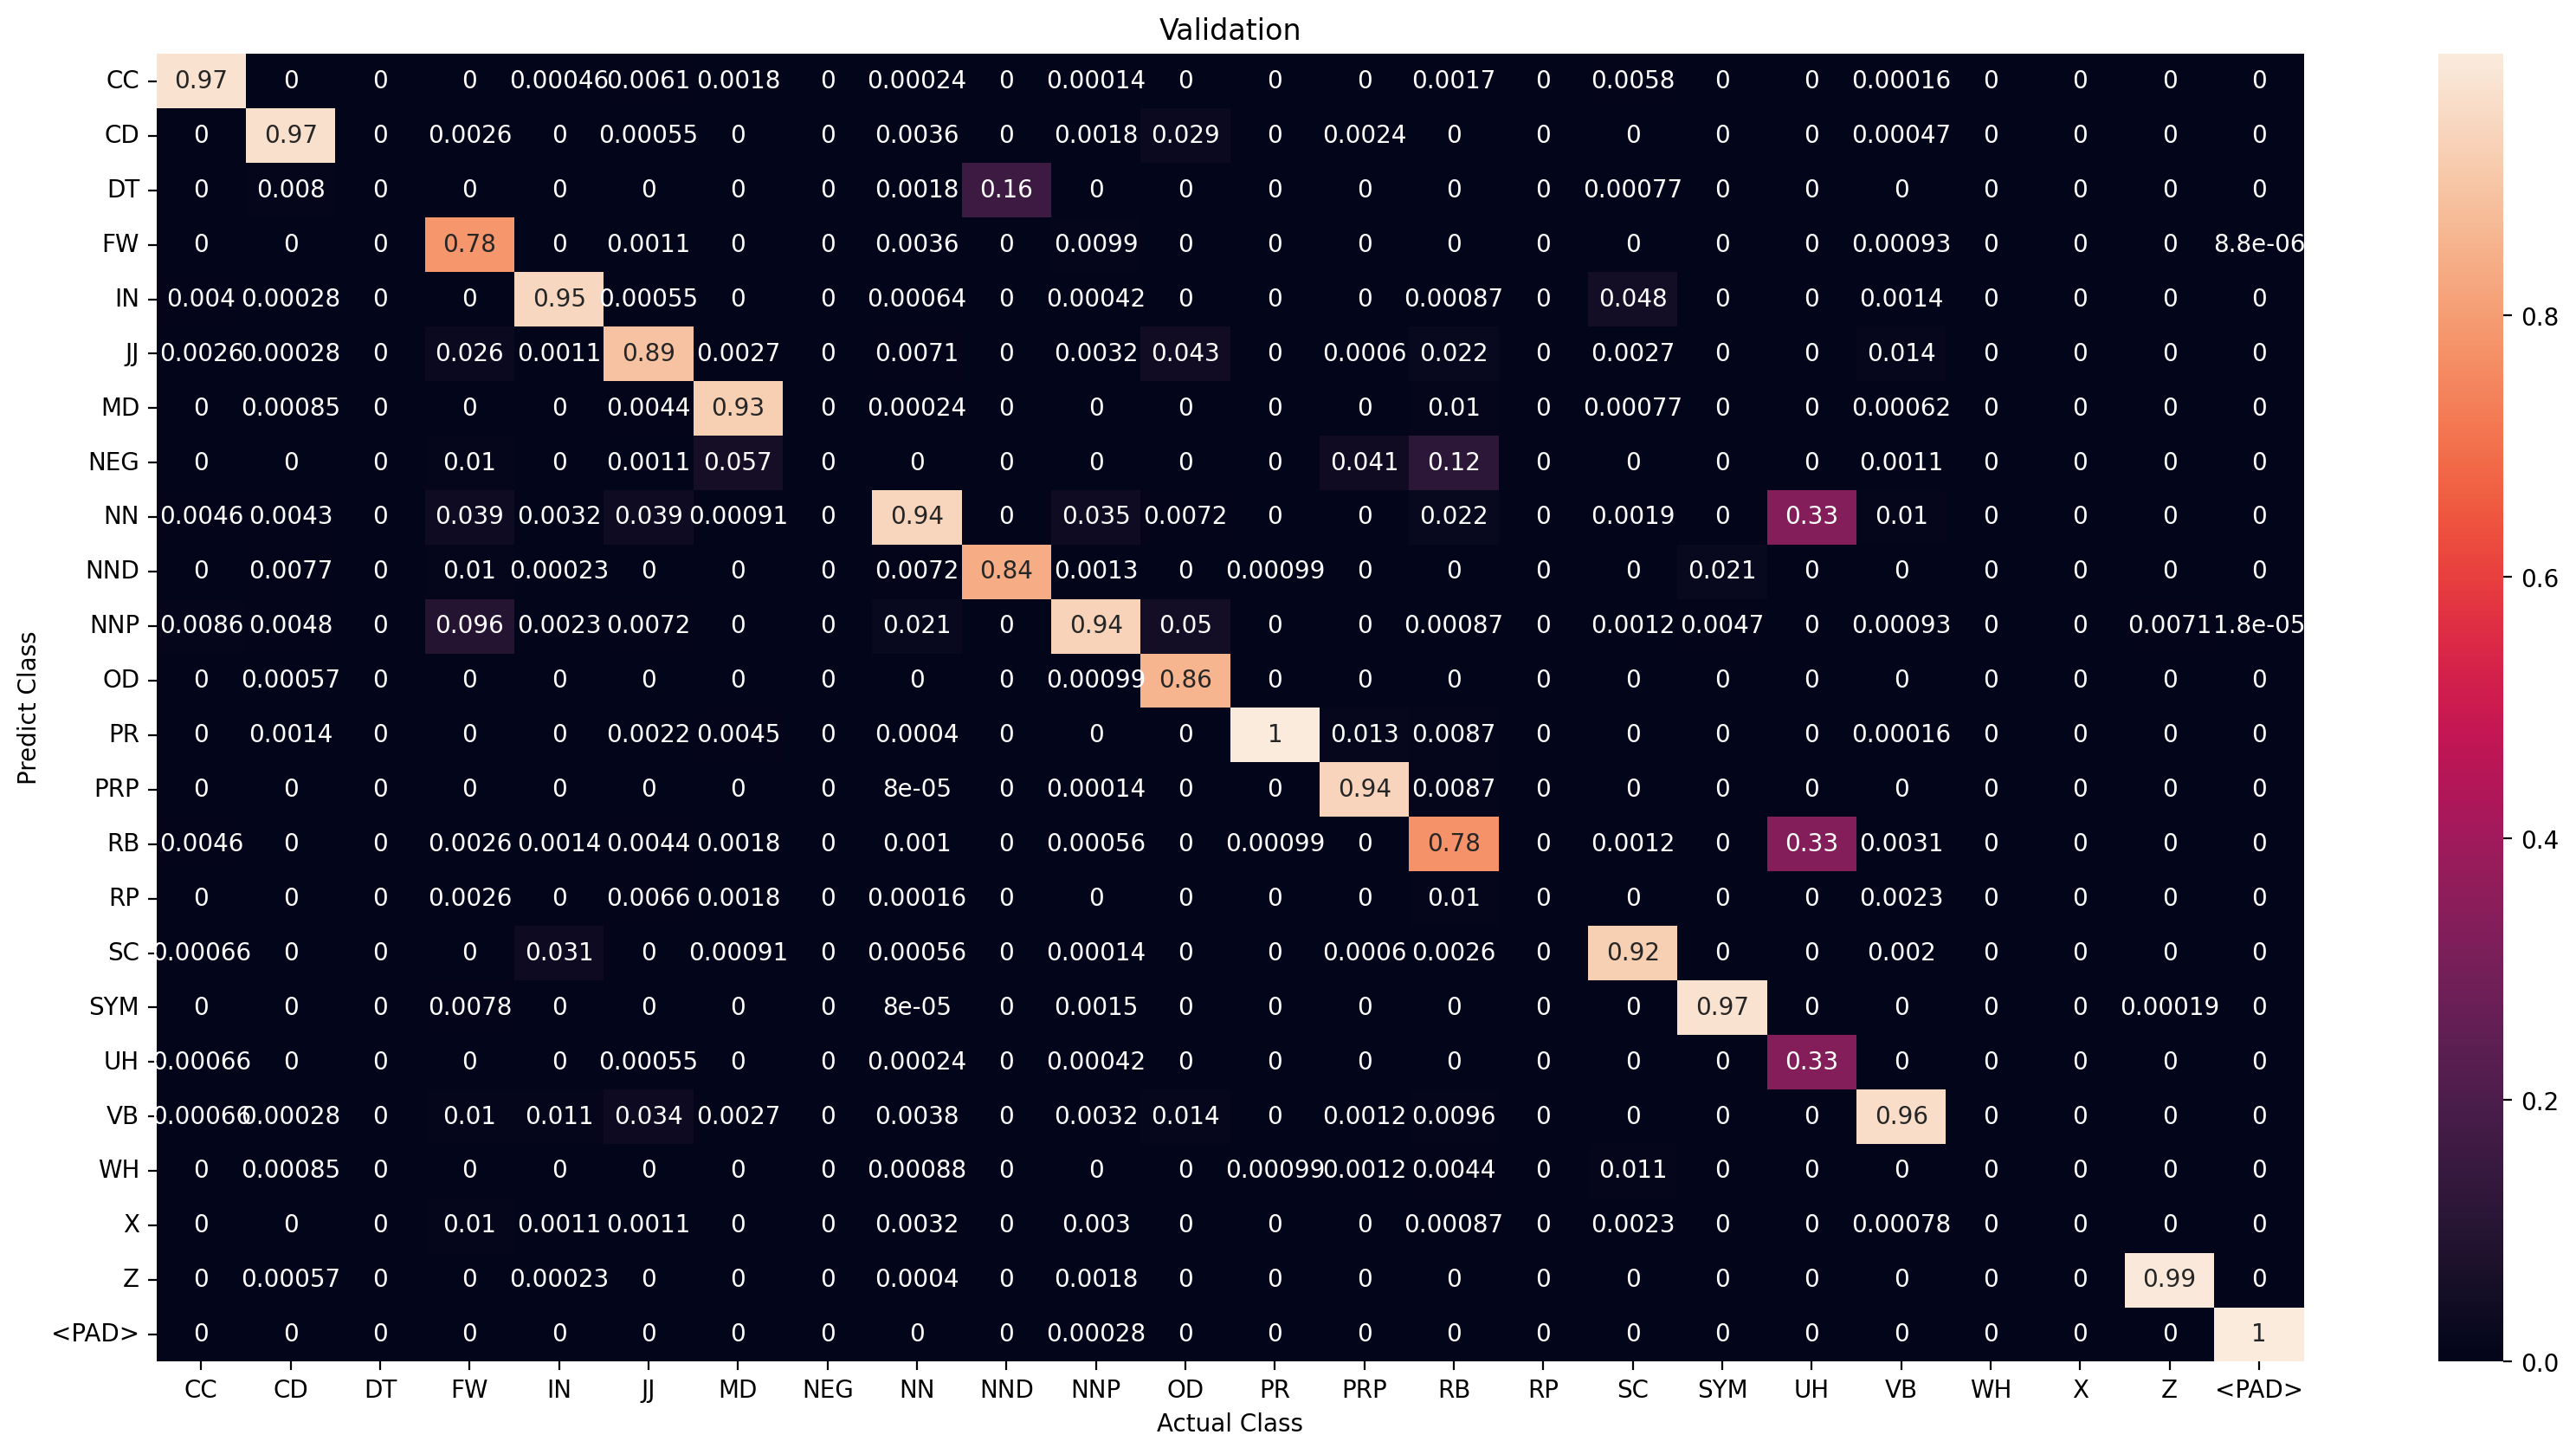

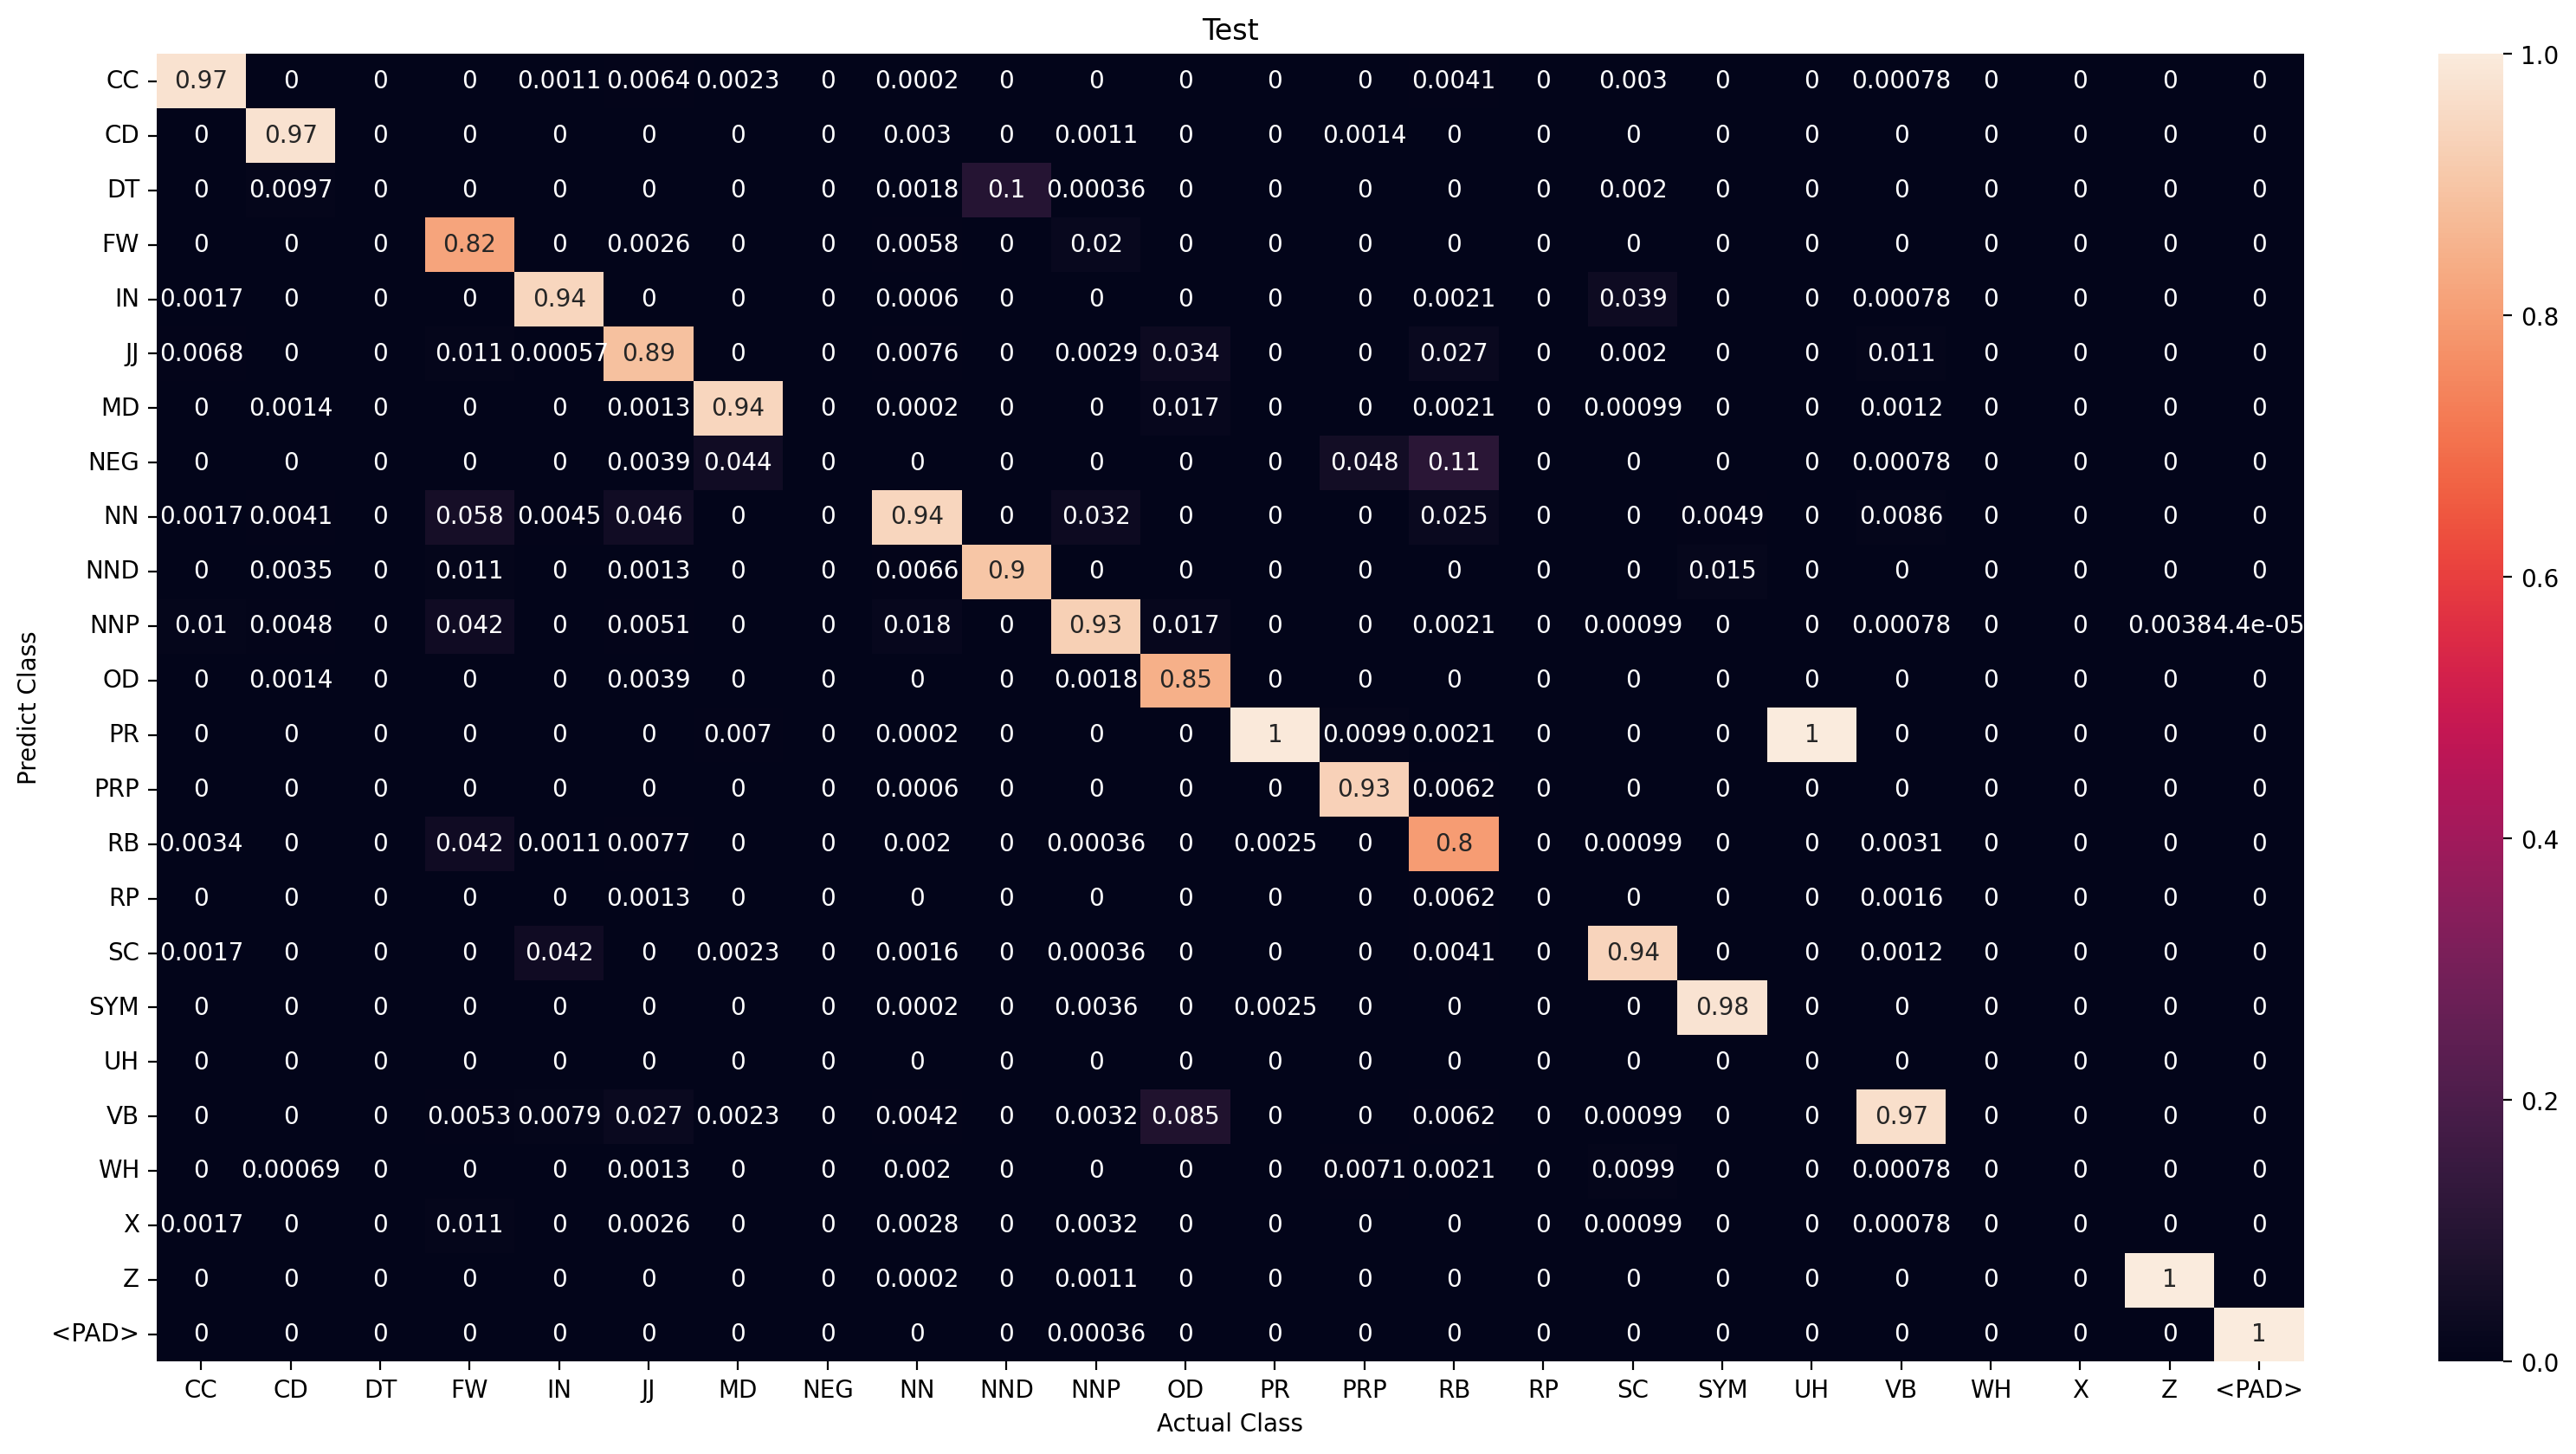

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5227       | CC    : 109      |
| CD    : 12904  | CD    : 12769      | CD    : 135      |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1454       | FW    : 243      |
| IN    : 15290  | IN    : 15163      | IN    : 127      |
| JJ    : 7049   | JJ    : 6504       | JJ    : 545      |
| MD    : 3783   | MD    : 3728       | MD    : 55       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44009      | NN    : 760      |
| NND   : 998    | NND   : 525        | NND   : 473      |
| NNP   : 24884  | NNP   : 24410      | NNP   : 474      |
| OD    : 550    | OD    : 539        | OD    : 11       |
| PR    : 3878   | PR    : 3736       | PR    : 142      |
| PRP   : 5355   | PRP   : 5320       | PRP   : 35       |
| RB    : 3517   | RB    : 3360       | RB    : 157      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11285
Wrong prediction            : 649
Percentage correct oov pred : 94.56175632646222

Validation
Number OOV token            : 3261
Correct prediction          : 2957
Wrong prediction            : 304
Percentage correct oov pred : 90.67770622508434

Test
Number OOV token            : 1367
Correct prediction          : 1229
Wrong prediction            : 138
Percentage correct oov pred : 89.90490124359913



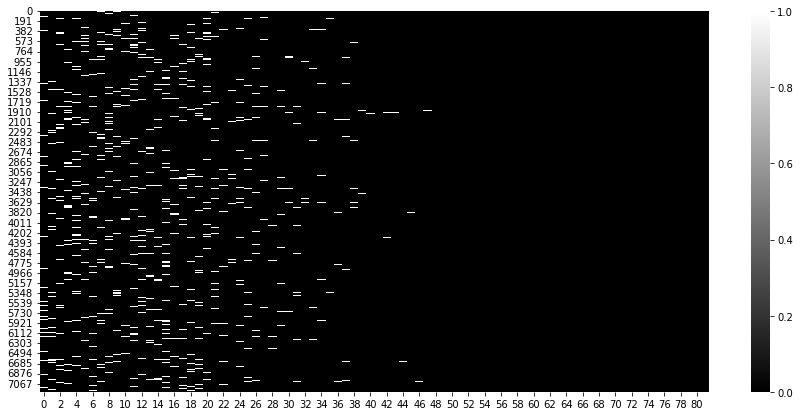

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

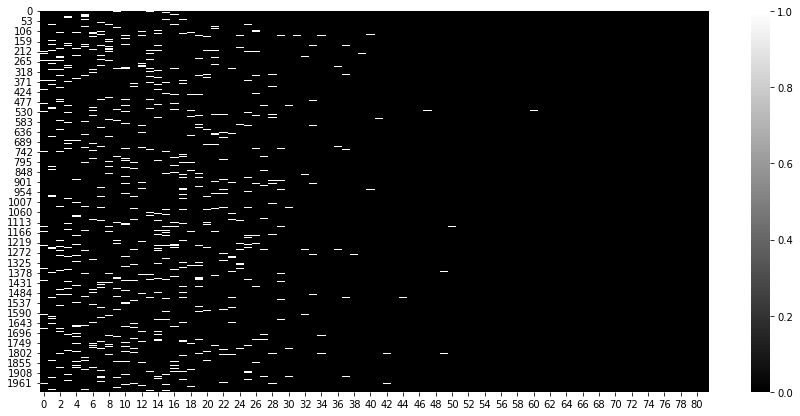

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

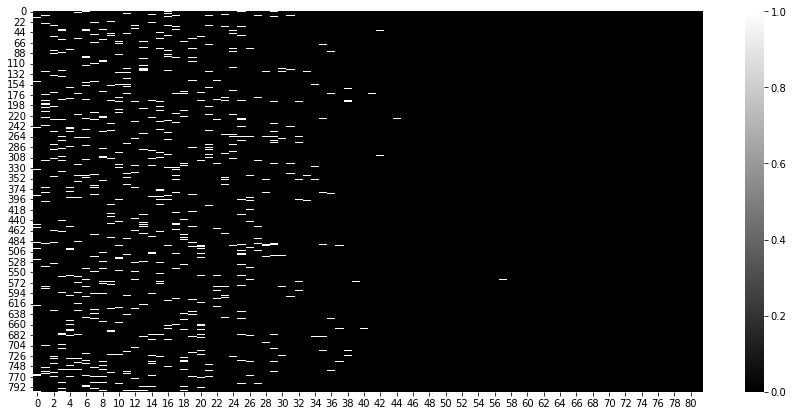

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);